# Выбор локации для скважины

В этом проекте предстоит работа с добывающей компанией «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
# import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

!pip install phik -q
import phik
from phik.report import plot_correlation_matrix

RANDOM_STATE = 42
VALID_SIZE = 0.25

## Загрузка и подготовка данных

### Первый регион

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
geo_data_0.info()
geo_data_0.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(100000, 5)

### Второй регион

In [4]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
geo_data_1.info()
geo_data_1.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(100000, 5)

### Третий регион

In [6]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
geo_data_2.info()
geo_data_2.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(100000, 5)

### Поиск пропусков

Исходя из результата работы метода info(), видим, что пропуски отсутствуют.

### Обработка дубликатов

Хоть идентификаторы и должны быть уникальными, возможно, что одна и та же скважина может иметь разные признаки и иметь различный объём запасов (к примеру, в разное время). Руководствуясь этим, будем искать строки-дубликаты, в которых полностью совпадают данные. 

In [8]:
geo_data_0.duplicated().sum()

0

In [9]:
geo_data_1.duplicated().sum()

0

In [10]:
geo_data_2.duplicated().sum()

0

Дубликаты отсутствуют. 

### Проверка на корректность типов данных столбцов датасетов и самих данных 

Исходя из результата работы метода info(), видим, что во всех столбцах всех датасетов значения имеют корректный тип данных. Единственное - для экономии памяти заменим числовые типы 64 в 32.

In [11]:
a = ['f0', 'f1', 'f2', 'product']

#Первый регион
for i in a:
    geo_data_0[i] = geo_data_0[i].astype(np.float32)

#Второй регион
for i in a:
    geo_data_1[i] = geo_data_1[i].astype(np.float32)
    
#Третий регион
for i in a:
    geo_data_2[i] = geo_data_2[i].astype(np.float32)

### Исследовательский анализ данных

#### Первый регион

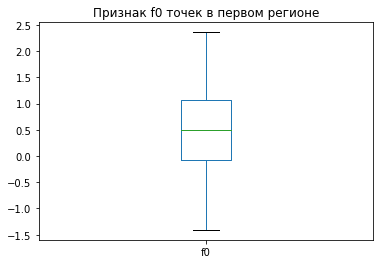

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64

In [12]:
geo_data_0['f0'].plot.box()
plt.title('Признак f0 точек в первом регионе')
plt.show()
geo_data_0['f0'].describe()

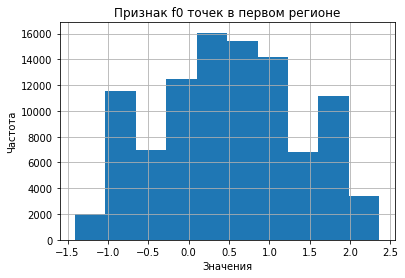

In [13]:
geo_data_0['f0'].hist()
plt.title('Признак f0 точек в первом регионе')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Среднее значение признака f0 - 0.5. Минимальное значение - -1.41, максимальное - 2.36. Наибольшее количество точек сосредоточено в интервале от 0 до 1.

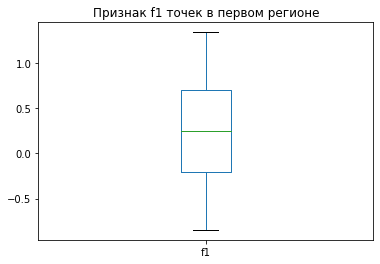

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848219
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64

In [14]:
geo_data_0['f1'].plot.box()
plt.title('Признак f1 точек в первом регионе')
plt.show()
geo_data_0['f1'].describe()

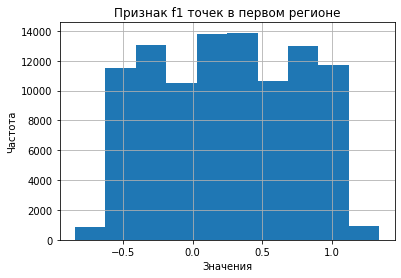

In [15]:
geo_data_0['f1'].hist()
plt.title('Признак f1 точек в первом регионе')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Среднее значение признака f1 - 0.25. Минимальное значение - -0.85, максимальное - 1.34. Наибольшее количество точек сосредоточено в интервале от -0.2 до 0.7.

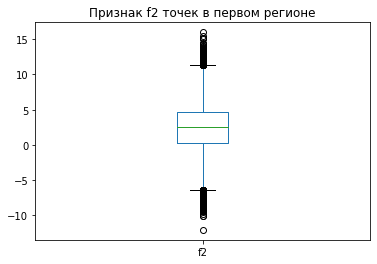

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64

In [16]:
geo_data_0['f2'].plot.box()
plt.title('Признак f2 точек в первом регионе')
plt.show()
geo_data_0['f2'].describe()

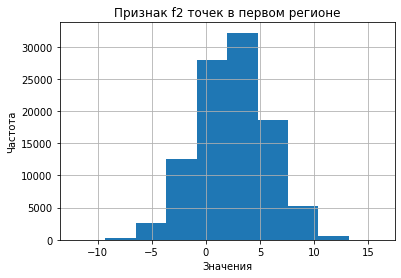

In [17]:
geo_data_0['f2'].hist()
plt.title('Признак f2 точек в первом регионе')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Среднее значение признака f2 - 2.5. Минимальное значение - -12.09, максимальное - 16. Наибольшее количество точек сосредоточено в интервале от 0 до 5.

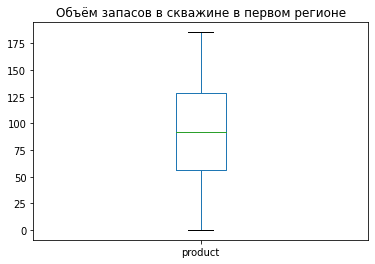

count    100000.000000
mean         92.500000
std          44.288692
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564087
max         185.364349
Name: product, dtype: float64

In [18]:
geo_data_0['product'].plot.box()
plt.title('Объём запасов в скважине в первом регионе')
plt.show()
geo_data_0['product'].describe()

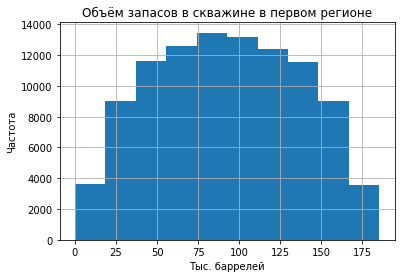

In [19]:
geo_data_0['product'].hist()
plt.title('Объём запасов в скважине в первом регионе')
plt.xlabel('Тыс. баррелей')
plt.ylabel('Частота')
plt.show()

Среднее значение объёма запасов в скважине - 92.5. Минимальное значение - 0, максимальное - 185.36. Наибольшее количество точек сосредоточено в интервале от 56.5 до 128.56.

#### Второй регион

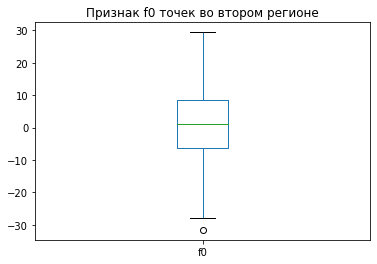

count    100000.000000
mean          1.141296
std           8.965931
min         -31.609575
25%          -6.298551
50%           1.153055
75%           8.621016
max          29.421755
Name: f0, dtype: float64

In [20]:
geo_data_1['f0'].plot.box()
plt.title('Признак f0 точек во втором регионе')
plt.show()
geo_data_1['f0'].describe()

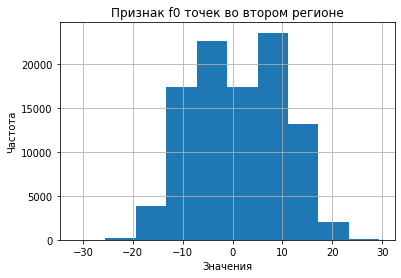

In [21]:
geo_data_1['f0'].hist()
plt.title('Признак f0 точек во втором регионе')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Среднее значение признака f0 - 1.14. Минимальное значение - -31.61, максимальное - 29.42. Наибольшее количество точек сосредоточено в интервале примерно от -7 до 10.

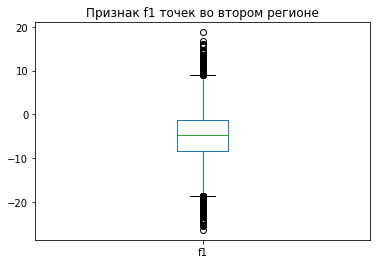

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358599
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734062
Name: f1, dtype: float64

In [22]:
geo_data_1['f1'].plot.box()
plt.title('Признак f1 точек во втором регионе')
plt.show()
geo_data_1['f1'].describe()

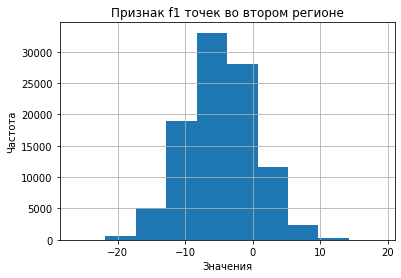

In [23]:
geo_data_1['f1'].hist()
plt.title('Признак f1 точек во втором регионе')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Среднее значение признака f1 - -4.8. Минимальное значение - -26.36, максимальное - 18.73. Наибольшее количество точек сосредоточено в интервале примерно от -8 до 0.

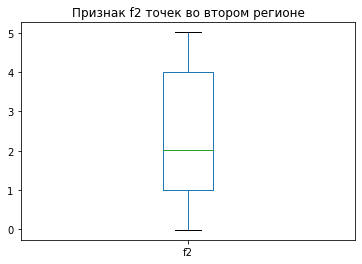

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64

In [24]:
geo_data_1['f2'].plot.box()
plt.title('Признак f2 точек во втором регионе')
plt.show()
geo_data_1['f2'].describe()

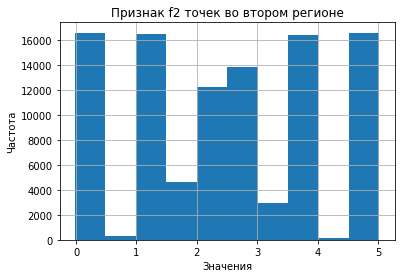

In [25]:
geo_data_1['f2'].hist()
plt.title('Признак f2 точек во втором регионе')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Среднее значение признака f2 - 2.49. Минимальное значение - -0.02, максимальное - 5.02. Наибольшее количество точек сосредоточено в следующих интервалах: 0-0.5, 1-1.4, 2-3, 3.5-4, 4.5-5.

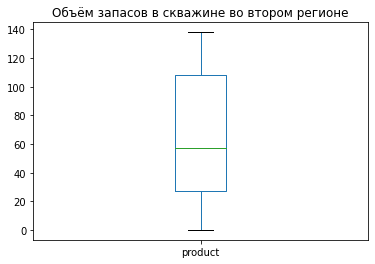

count    100000.000000
mean         68.824997
std          45.944424
min           0.000000
25%          26.953260
50%          57.085625
75%         107.813042
max         137.945404
Name: product, dtype: float64

In [26]:
geo_data_1['product'].plot.box()
plt.title('Объём запасов в скважине во втором регионе')
plt.show()
geo_data_1['product'].describe()

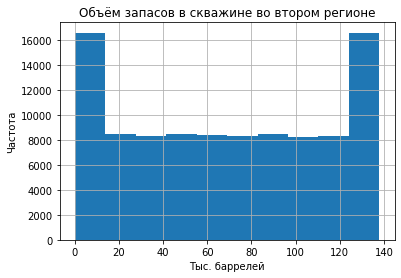

In [27]:
geo_data_1['product'].hist()
plt.title('Объём запасов в скважине во втором регионе')
plt.xlabel('Тыс. баррелей')
plt.ylabel('Частота')
plt.show()

Среднее значение объёма запасов в скважине - 68.82. Минимальное значение - 0, максимальное - 137.95. Наибольшее количество точек сосредоточено в интервалах примерно от 0 до 15 и от 125 до 137.

#### Третий регион

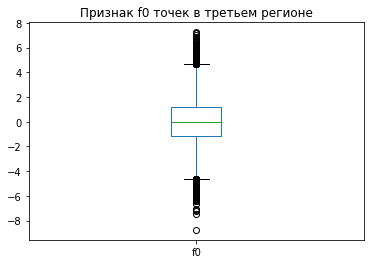

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238263
Name: f0, dtype: float64

In [28]:
geo_data_2['f0'].plot.box()
plt.title('Признак f0 точек в третьем регионе')
plt.show()
geo_data_2['f0'].describe()

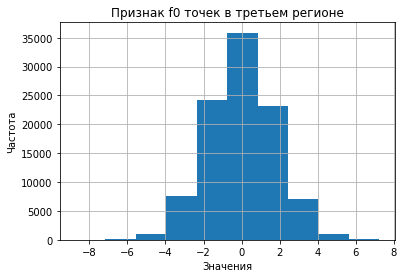

In [29]:
geo_data_2['f0'].hist()
plt.title('Признак f0 точек в третьем регионе')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Среднее значение признака f0 - 0. Минимальное значение - -8.76, максимальное - 7.24. Наибольшее количество точек сосредоточено в интервале от -1.16 до 1.16.

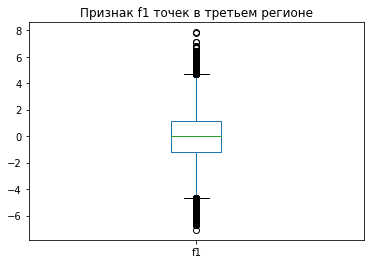

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64

In [30]:
geo_data_2['f1'].plot.box()
plt.title('Признак f1 точек в третьем регионе')
plt.show()
geo_data_2['f1'].describe()

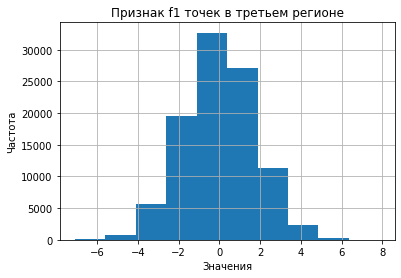

In [31]:
geo_data_2['f1'].hist()
plt.title('Признак f1 точек в третьем регионе')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Среднее значение признака f1 - 0. Минимальное значение - -7.08, максимальное - 7.84. Наибольшее количество точек сосредоточено в интервале от -1 до 2.

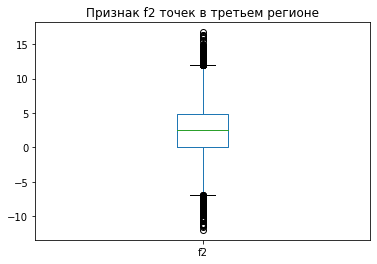

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739403
Name: f2, dtype: float64

In [32]:
geo_data_2['f2'].plot.box()
plt.title('Признак f2 точек в третьем регионе')
plt.show()
geo_data_2['f2'].describe()

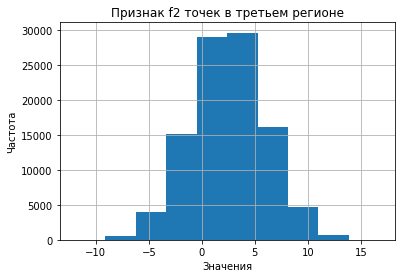

In [33]:
geo_data_2['f2'].hist()
plt.title('Признак f2 точек в третьем регионе')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Среднее значение признака f2 - 2.5. Минимальное значение - -11.97, максимальное - 16.74. Наибольшее количество точек сосредоточено в интервале от 0 до 5.

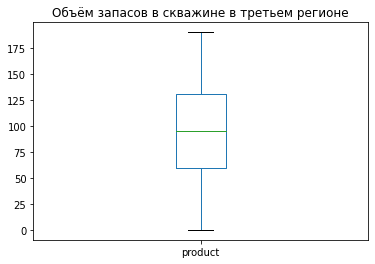

count    100000.000000
mean         95.000000
std          44.749920
min           0.000000
25%          59.450439
50%          94.925613
75%         130.595024
max         190.029831
Name: product, dtype: float64

In [34]:
geo_data_2['product'].plot.box()
plt.title('Объём запасов в скважине в третьем регионе')
plt.show()
geo_data_2['product'].describe()

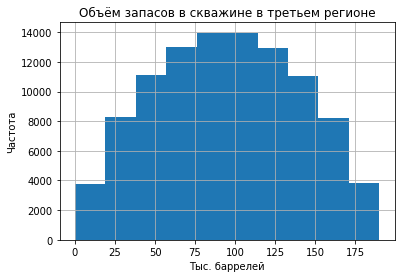

In [35]:
geo_data_2['product'].hist()
plt.title('Объём запасов в скважине в третьем регионе')
plt.xlabel('Тыс. баррелей')
plt.ylabel('Частота')
plt.show()

Среднее значение объёма запасов в скважине - 95. Минимальное значение - 0, максимальное - 190.03. Наибольшее количество точек сосредоточено в интервале от 60 до 130.

#### Корреляционный анализ

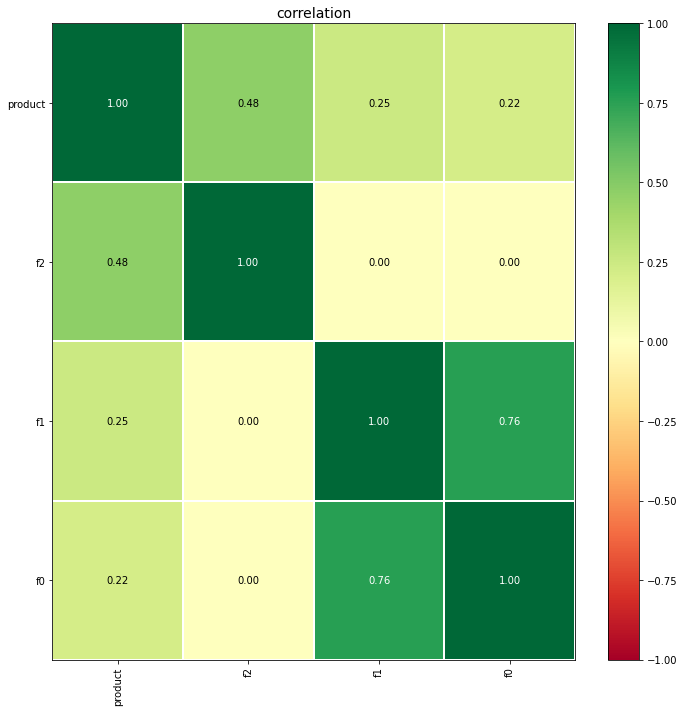

In [36]:
#Первый регион
interval_cols = ['f0', 'f1', 'f2', 'product']
corr_matrix_0 = geo_data_0.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    corr_matrix_0.values,
    x_labels=corr_matrix_0.columns,
    y_labels=corr_matrix_0.index,
    figsize=(10,10)
)

По построенной матрице корреляции можно сделать следующие выводы:
- Мультиколлинеарность не прослеживается;
- Связь отсутствует между признаками:
  - *f2* и *f1*;
  - *f2* и *f0*;
- Слабая связь наблюдается между признаками:
  - *product* и *f1*;
  - *product* и *f0*;
- Умеренная связь наблюдается между признаками:
  - *product* и *f2*;
- Высокая связь наблюдается между признаками:
  - *f0* и *f1*.

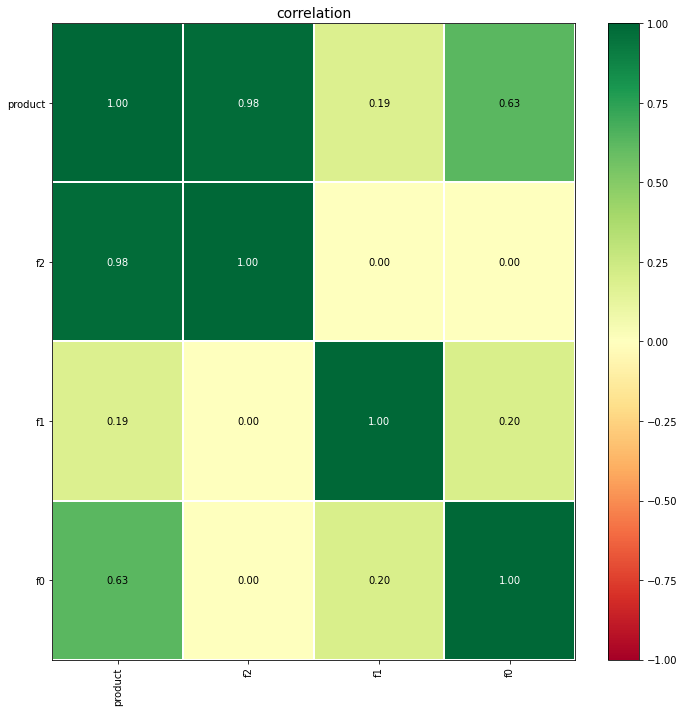

In [37]:
#Второй регион
interval_cols = ['f0', 'f1', 'f2', 'product']
corr_matrix_1 = geo_data_1.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    corr_matrix_1.values,
    x_labels=corr_matrix_1.columns,
    y_labels=corr_matrix_1.index,
    figsize=(10,10)
)

По построенной матрице корреляции можно сделать следующие выводы:
- Мультиколлинеарность не прослеживается;
- Связь отсутствует между признаками:
  - *f2* и *f1*;
  - *f2* и *f0*;
- Слабая связь наблюдается между признаками:
  - *product* и *f1*;
  - *f1* и *f0*;
- Заметная связь наблюдается между признаками:
  - *product* и *f0*;
- Весьма высокая связь наблюдается между признаками:
  - *product* и *f2*.

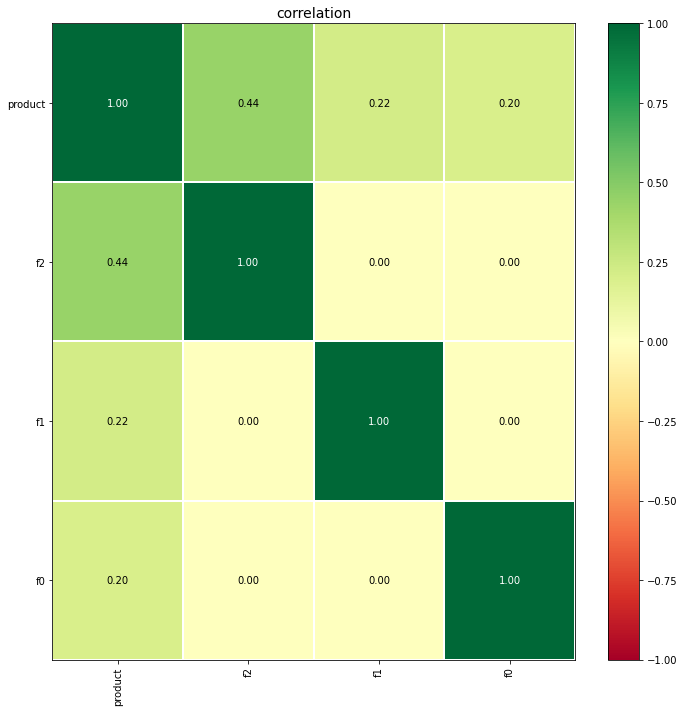

In [38]:
#Третий регион
interval_cols = ['f0', 'f1', 'f2', 'product']
corr_matrix_2 = geo_data_2.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    corr_matrix_2.values,
    x_labels=corr_matrix_2.columns,
    y_labels=corr_matrix_2.index,
    figsize=(10,10)
)

По построенной матрице корреляции можно сделать следующие выводы:
- Мультиколлинеарность не прослеживается;
- Связь отсутствует между признаками:
  - *f2* и *f1*;
  - *f2* и *f0*;
  - *f1* и *f0*;
- Слабая связь наблюдается между признаками:
  - *product* и *f1*;
  - *product* и *f0*;
- Умеренная связь наблюдается между признаками:
  - *product* и *f2*.

### Промежуточный вывод

На данном этапе была изучена общая информация об объёмах запасах в скважинах 3-х регионов, также ознакомились с признаками точек. Помимо этого, была проведена предобработка данных: выявлено отсутствие пропусков; преобразованы типы данных для некоторых столбцов для удобства в дальнейшей работе; выявлено отсутствие дубликатов. Также был проведён исследовательский анализ данных: для каждого признака 3-х датасетов были построены и проанализированы графики, а также были посчитаны и проанализированы коэффициенты корреляции для различных признаков.

## Обучение и проверка модели

In [39]:
def split_data(data):
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    return train_test_split(features, target, test_size=VALID_SIZE, random_state=RANDOM_STATE)

X_train_0, X_valid_0, y_train_0, y_valid_0 = split_data(geo_data_0)
X_train_1, X_valid_1, y_train_1, y_valid_1 = split_data(geo_data_1)
X_train_2, X_valid_2, y_train_2, y_valid_2 = split_data(geo_data_2)

In [40]:
num_names = ['f0', 'f1', 'f2']

def scale(X_train, X_valid):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train[num_names])
    X_valid = scaler.transform(X_valid[num_names])
    X_train = pd.DataFrame(X_train, columns=num_names)
    X_valid = pd.DataFrame(X_valid, columns=num_names)
    return X_train, X_valid

X_train_0, X_valid_0 = scale(X_train_0, X_valid_0)
X_train_1, X_valid_1 = scale(X_train_1, X_valid_1)
X_train_2, X_valid_2 = scale(X_train_2, X_valid_2)

In [41]:
def train_and_predict(X_train, y_train, X_valid):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    return predictions

predictions_0 = train_and_predict(X_train_0, y_train_0, X_valid_0)
predictions_1 = train_and_predict(X_train_1, y_train_1, X_valid_1)
predictions_2 = train_and_predict(X_train_2, y_train_2, X_valid_2)

In [42]:
results_0 = pd.DataFrame({'predictions': predictions_0, 'actual': y_valid_0})
results_1 = pd.DataFrame({'predictions': predictions_1, 'actual': y_valid_1})
results_2 = pd.DataFrame({'predictions': predictions_2, 'actual': y_valid_2})

In [43]:
def print_metrics(y_valid, predictions):
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    mean_pred = predictions.mean()
    print(f"Средний запас предсказанного сырья: {mean_pred:.2f} тыс. баррелей")
    print(f"RMSE модели: {rmse:.2f} тыс. баррелей")

print("Первый регион:")
print_metrics(y_valid_0, predictions_0)
print("Второй регион:")
print_metrics(y_valid_1, predictions_1)
print("Третий регион:")
print_metrics(y_valid_2, predictions_2)

Первый регион:
Средний запас предсказанного сырья: 92.40 тыс. баррелей
RMSE модели: 37.76 тыс. баррелей
Второй регион:
Средний запас предсказанного сырья: 68.71 тыс. баррелей
RMSE модели: 0.89 тыс. баррелей
Третий регион:
Средний запас предсказанного сырья: 94.77 тыс. баррелей
RMSE модели: 40.15 тыс. баррелей


### Первый регион

In [44]:
X_0 = geo_data_0.drop('product', axis=1)
y_0 = geo_data_0['product']

X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(X_0, y_0, random_state=RANDOM_STATE)


scaler_0 = StandardScaler()

X_train_0 = scaler_0.fit_transform(X_train_0[num_names])
X_valid_0 = scaler_0.transform(X_valid_0[num_names])

X_train_0 = pd.DataFrame(X_train_0, columns=num_names)
X_valid_0 = pd.DataFrame(X_valid_0, columns=num_names)


model_0 = LinearRegression()

model_0.fit(X_train_0, y_train_0)

predictions_0 = model_0.predict(X_valid_0)


rmse_0 = mean_squared_error(y_valid_0, predictions_0, squared=False)

In [45]:
results_0 = pd.DataFrame({'predictions': predictions_0, 'actual': y_valid_0})

In [46]:
print(f"Средний запас предсказанного сырья в первом регионе: {predictions_0.mean():.2f} тыс. баррелей")
print(f"RMSE модели для первого региона: {rmse_0:.2f} тыс. баррелей")

Средний запас предсказанного сырья в первом регионе: 92.40 тыс. баррелей
RMSE модели для первого региона: 37.76 тыс. баррелей


В среднем модель ошибается примерно на 37.76 тысяч баррелей.

### Второй регион

In [47]:
X_1 = geo_data_1.drop('product', axis=1)
y_1 = geo_data_1['product']

X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_1, y_1, random_state=RANDOM_STATE)


scaler_1 = StandardScaler()

X_train_1 = scaler_1.fit_transform(X_train_1[num_names])
X_valid_1 = scaler_1.transform(X_valid_1[num_names])

X_train_1 = pd.DataFrame(X_train_1, columns=num_names)
X_valid_1 = pd.DataFrame(X_valid_1, columns=num_names)


model_1 = LinearRegression()

model_1.fit(X_train_1, y_train_1)

predictions_1 = model_1.predict(X_valid_1)


rmse_1 = mean_squared_error(y_valid_1, predictions_1, squared=False)

In [48]:
results_1 = pd.DataFrame({'predictions': predictions_1, 'actual': y_valid_1})

In [49]:
print(f"Средний запас предсказанного сырья во втором регионе: {predictions_1.mean():.2f} тыс. баррелей")
print(f"RMSE модели для второго региона: {rmse_1:.2f} тыс. баррелей")

Средний запас предсказанного сырья во втором регионе: 68.71 тыс. баррелей
RMSE модели для второго региона: 0.89 тыс. баррелей


В среднем модель ошибается примерно на 0.89 тысяч баррелей. 

### Третий регион

In [50]:
X_2 = geo_data_2.drop('product', axis=1)
y_2 = geo_data_2['product']

X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_2, y_2, random_state=RANDOM_STATE)


scaler_2 = StandardScaler()

X_train_2 = scaler_2.fit_transform(X_train_2[num_names])
X_valid_2 = scaler_2.transform(X_valid_2[num_names])

X_train_2 = pd.DataFrame(X_train_2, columns=num_names)
X_valid_2 = pd.DataFrame(X_valid_2, columns=num_names)


model_2 = LinearRegression()

model_2.fit(X_train_2, y_train_2)

predictions_2 = model_2.predict(X_valid_2)


rmse_2 = mean_squared_error(y_valid_2, predictions_2, squared=False)

In [51]:
results_2 = pd.DataFrame({'predictions': predictions_2, 'actual': y_valid_2})

In [52]:
print(f"Средний запас предсказанного сырья в третьем регионе: {predictions_2.mean():.2f} тыс. баррелей")
print(f"RMSE модели для третьего региона: {rmse_2:.2f} тыс. баррелей")

Средний запас предсказанного сырья в третьем регионе: 94.77 тыс. баррелей
RMSE модели для третьего региона: 40.15 тыс. баррелей


В среднем модель ошибается примерно на 40.15 тысяч баррелей.

### Промежуточный вывод

На данном этапе было проведено обучение моделей линейной регрессии. Рассчитав оценку RMSE моделей, можно сделать вывод, что менее всего ошибается модель для второго региона.

## Подготовка к расчёту прибыли

In [53]:
BUDGET = 10**10
REVENUE_PER_BARREL = 450000
NUM_WELLS = 200
TOTAL_POINTS = 500

In [54]:
cost_per_well = BUDGET / NUM_WELLS
min_product = cost_per_well / REVENUE_PER_BARREL
print(f"Достаточный объём сырья для безубыточной разработки новой скважины: {min_product:.2f} тыс. баррелей")

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей


### Промежуточный вывод

На данном этапе было определено, сколько сырья необходимо для безубыточной разработки одной скважины. Наиболее близко получившееся значение к среднему запасу в третьем регионе (94.77 тыс. баррелей).

## Расчёт прибыли и рисков 

### Расчёт прибыли по выбранным скважинам и предсказаниям модели

In [55]:
#def calculate_profit(predictions, actual):
#    selected_indices = predictions.nlargest(NUM_WELLS).index
#    selected_actual = actual[selected_indices]
#    total_product = selected_actual.sum()


    # debug
#    if selected_indices.shape[0] != selected_actual.shape[0]:
#        print(f"Shape mismatch! You should take {selected_indices.shape[0]} while {selected_actual.shape[0]} target values were taken!")


#    profit = total_product * REVENUE_PER_BARREL - BUDGET
#    return profit

In [56]:
def calculate_profit(data):
    top_wells = data.nlargest(NUM_WELLS, 'predictions')
    total_product = top_wells['actual'].sum()

    profit = total_product * REVENUE_PER_BARREL - BUDGET
    return profit

In [57]:
profit_0 = calculate_profit(results_0)
profit_1 = calculate_profit(results_1)
profit_2 = calculate_profit(results_2)

print(f"Прибыль для первого региона: {profit_0:.2f} рублей")
print(f"Прибыль для второго региона: {profit_1:.2f} рублей")
print(f"Прибыль для третьего региона: {profit_2:.2f} рублей")

Прибыль для первого региона: 3359141210.94 рублей
Прибыль для второго региона: 2415088671.88 рублей
Прибыль для третьего региона: 2598571777.34 рублей


### Расчёт рисков и прибыли для каждого региона

In [65]:
def bootstrap_profit(data, n=1000, random_state=RANDOM_STATE):
    profits = []
    total_points = TOTAL_POINTS # сэмпл размером 25 тысяч - не совсем то, что нужно (
    STATE = np.random.RandomState(random_state)
    for _ in range(n):
        sample_data = data.sample(n=total_points, replace=True, random_state=STATE)
        profit = calculate_profit(sample_data)
        profits.append(profit)
    return pd.Series(profits)

profits_0 = bootstrap_profit(results_0)
profits_1 = bootstrap_profit(results_1)
profits_2 = bootstrap_profit(results_2)

In [59]:
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index])

3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
2    2
2    2
2    2
2    2
dtype: int64

In [60]:
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index][:5])

2    3
3    3
4    3
0    2
1    2
dtype: int64

In [62]:
def print_statistics(profits):
    mean_profit = profits.mean()
    lower_bound = profits.quantile(0.025)
    upper_bound = profits.quantile(0.975)
    risk_of_loss = np.mean(profits < 0)
    print(f"Средняя прибыль: {mean_profit:.2f} рублей")
    print(f"95%-й доверительный интервал: ({lower_bound:.2f}, {upper_bound:.2f}) рублей")
    print(f"Риск убытков: {risk_of_loss:.2%}")
    return mean_profit, lower_bound, upper_bound, risk_of_loss

Первый регион:
Средняя прибыль: 399575447.95 рублей
95%-й доверительный интервал: (-110467795.41, 897460441.89) рублей
Риск убытков: 6.00%


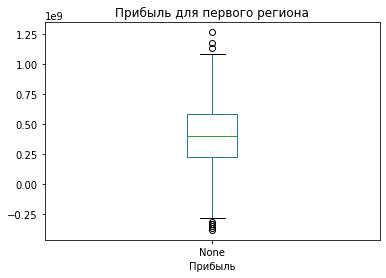

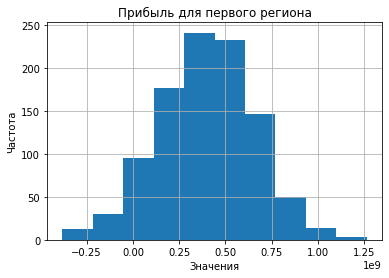

Второй регион:
Средняя прибыль: 452050113.18 рублей
95%-й доверительный интервал: (61684165.04, 845341608.89) рублей
Риск убытков: 1.50%


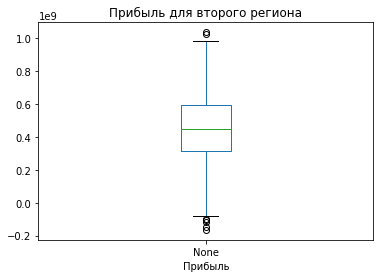

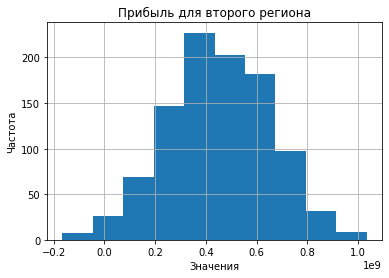

Третий регион:
Средняя прибыль: 375009881.15 рублей
95%-й доверительный интервал: (-144766826.17, 888389975.59) рублей
Риск убытков: 8.00%


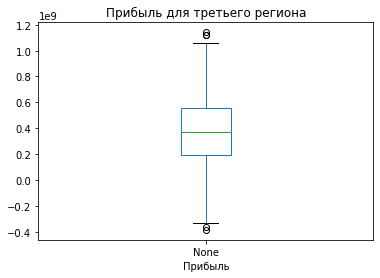

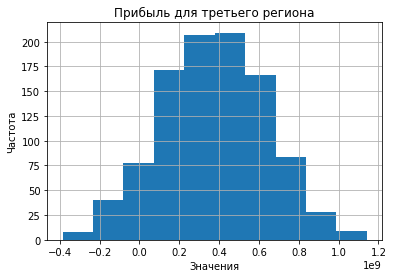

In [66]:
def boxplot_and_hist(profits, title):
    mean_profit, lower_bound, upper_bound, _ = print_statistics(profits)
    
    #Boxplot
    profits.plot.box()
    plt.title(f'Прибыль для {title} региона')
    plt.xlabel('Прибыль')
    plt.show()
    
    # Histogram
    profits.hist()
    plt.title(f'Прибыль для {title} региона')
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.show()

print("Первый регион:")
boxplot_and_hist(profits_0, 'первого')

print("Второй регион:")
boxplot_and_hist(profits_1, 'второго')

print("Третий регион:")
boxplot_and_hist(profits_2, 'третьего')

### Промежуточный вывод

На данном этапе были выбраны скважины с максимальными значениями предсказаний и рассчитана прибыль для полученного объёма сырья для каждого региона, а также посчитаны риск и прибыль для каждого региона. 

На основании проведённых расчётов следует выбрать первый регион, т.к. он имеет наибольшую среднюю прибыль и имеет минимальный риск убытков (впрочем, все регионы имеют нулевой риск убытков).

## Общий вывод

В данном проекте была проведена работа с добывающей компанией «ГлавРосГосНефть», для которой требуется решить, где бурить новую скважину. 

Были решены 2 задачи, в ходе которых были разработаны модели машинного обучения и выбраны лучшие модели, предсказывающие уровень удовлетворённости сотрудника на основе данных заказчика и увольнение сотрудника из компании. 

Были предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Была построена модель машинного обучения, которая определила регион, где добыча принесёт наибольшую прибыль - это *первый* регион. Также были проанализированы возможная прибыль и риски техникой *Bootstrap.*